# Lab 9 - PCC177/BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## NLP

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Implementar técncias de PLN para resolver um problema de classificação de texto tóxico em portugues.

Data da entrega : Fim do período

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-Lab.pdf"
- Envie o PDF via google [FORM](https://forms.gle/NeH2WCaqVG4n8iz88)

Este notebook é baseado em tensorflow e Keras.


# Importando bibliotecas e preparando o ambiente

Importando as bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten

Montando o seu drive no colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Vamos carregar a base de dados "*Brazilian Portuguese Hatespeech dataset*". Para detalhes sobre o dataset e o problema em si, veja o [link do Kaggle](https://www.kaggle.com/datasets/hrmello/brazilian-portuguese-hatespeech-dataset/).

In [3]:
# Ler o arquivo CSV hate_speech_binary_classification_train.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_treino.csv' pelo caminho real do seu arquivo CSV
dados = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_train.csv')

# Ler o arquivo CSV hate_speech_binary_classification_test.csv dentro da pasta de dataset do drive compartilhado.
# Substitua o 'caminho_do_arquivo_teste.csv' pelo caminho real do seu arquivo CSV
dados_teste = pd.read_csv('/content/drive/MyDrive/datasets/hate_speech_binary_classification_test.csv')

Mostrar as primeiras linhas do DataFrame

In [4]:
print(dados.head())

                                                text  \
0  -Odeio feministas só falam merda\n-Vamos fazer...   
1  CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...   
2  Diferença entre 'manifestante' e 'terrorista'....   
3  É legal pra um presidente 'grampear' uma corri...   
4  não há como negar a biologia....por mais que a...   

                                             protext  class  
0  -Odeio feministas só falam merda -Vamos fazer ...      1  
1  CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...      0  
2  Diferença entre 'manifestante' e 'terrorista'....      1  
3  É legal pra um presidente 'grampear' uma corri...      0  
4  não há como negar a biologia....por mais que a...      0  


## Pré-processando os dados

Selecionando colunas específicas

In [5]:
dados_brutos = dados.iloc[:, 0]
X = dados.iloc[:, 1] # Coluna dos dados pré-processados
y = dados.iloc[:, 2] # Coluna dos rótulos

X_test = dados_teste.iloc[:, 1]  # Coluna dos dados pré-processados
y_test = dados_teste.iloc[:, 2]  # Coluna dos rótulos

Mostrar as primeiras linhas de cada coluna

In [6]:
print("Dados brutos:")
print(dados_brutos.head())
print("\nRótulos:")
print(y.head())
print("\nDados preprocessados:")
print(X.head())

Dados brutos:
0    -Odeio feministas só falam merda\n-Vamos fazer...
1    CHEGOU DANDO CANTADA NO CARNAVAL:\n#CarnavalSe...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: text, dtype: object

Rótulos:
0    1
1    0
2    1
3    0
4    0
Name: class, dtype: int64

Dados preprocessados:
0    -Odeio feministas só falam merda -Vamos fazer ...
1    CHEGOU DANDO CANTADA NO CARNAVAL: #CarnavalSem...
2    Diferença entre 'manifestante' e 'terrorista'....
3    É legal pra um presidente 'grampear' uma corri...
4    não há como negar a biologia....por mais que a...
Name: protext, dtype: object


# Uma implementação ingênua para o problema

Abaixo uma implementação ingênua para o problema. Ela é ingênua por que desconsidera a ordem das palavras no texto.
Tente endendê-la e execute o treinamento.

### Pré-processamento

Primeira coisa é fixar as sementes para garantir a reproducibilidade dos resultados

In [7]:
np.random.seed(94)
tf.random.set_seed(94)

Codificação dos rótulos para 0 e 1

In [8]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y_test = encoder.transform(y_test)

Tokenização e sequenciamento dos textos

In [9]:
max_length = 280  # Define o tamanho máximo das sequências
vocab_size = 100000  # Define o tamanho do vocabulário

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
# Tokenização e sequenciamento dos textos de treino
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Tokenização e sequenciamento dos textos de teste
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length, padding='post', truncating='post')

Divisão dos dados em conjuntos de treino e validação

In [10]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

### Definição e treinamento do modelo

Definição do modelo

In [11]:
embedding_dim = 16

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compilação do modelo

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Visualizando os dados

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 16)           1600000   
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 32)                143392    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1743425 (6.65 MB)
Trainable params: 1743425 (6.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Treinamento do modelo

In [14]:
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=2)

Epoch 1/5
72/72 - 11s - loss: 0.6944 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5035 - 11s/epoch - 150ms/step
Epoch 2/5
72/72 - 4s - loss: 0.6932 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5035 - 4s/epoch - 58ms/step
Epoch 3/5
72/72 - 3s - loss: 0.6932 - accuracy: 0.4869 - val_loss: 0.6932 - val_accuracy: 0.4965 - 3s/epoch - 36ms/step
Epoch 4/5
72/72 - 1s - loss: 0.6932 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5035 - 1s/epoch - 17ms/step
Epoch 5/5
72/72 - 1s - loss: 0.6932 - accuracy: 0.4913 - val_loss: 0.6931 - val_accuracy: 0.4965 - 1s/epoch - 16ms/step


Plotando as curvas de loss

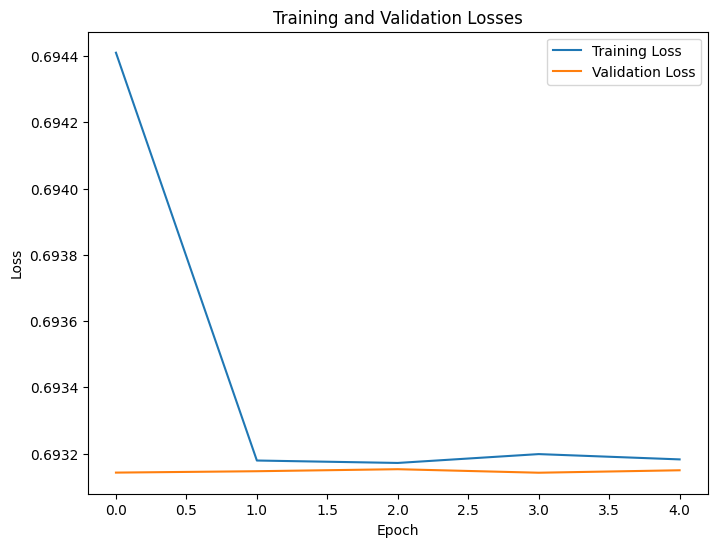

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Avaliação do modelo

Avaliar o modelo nos dados de teste


In [16]:
# Fazendo previsões no conjunto de teste
y_pred_prob = model.predict(padded_sequences_test)
y_pred = (y_pred_prob > 0.5).astype(int)

loss, accuracy = model.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste: {loss:.4f}")
print(f"Acurácia nos dados de teste: {accuracy:.4f}")

23/23 [==============================] - 0s 1ms/step
23/23 - 0s - loss: 0.6931 - accuracy: 0.5000 - 54ms/epoch - 2ms/step
Perda nos dados de teste: 0.6931
Acurácia nos dados de teste: 0.5000


Gerando o relatório de classificação

In [17]:
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotando os resultados

In [18]:
print("Classificação Report:")
for label, metrics in report.items():
    if label == 'accuracy':
        continue
    print(f"Class: {label}")
    print(f"\tPrecision: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Macro Avg: {report['macro avg']}")
print(f"Weighted Avg: {report['weighted avg']}")

Classificação Report:
Class: 0
	Precision: 0.0
	Recall: 0.0
	F1-score: 0.0
Class: 1
	Precision: 0.5
	Recall: 1.0
	F1-score: 0.6666666666666666
Class: macro avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Class: weighted avg
	Precision: 0.25
	Recall: 0.5
	F1-score: 0.3333333333333333
Macro Avg: {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}
Weighted Avg: {'precision': 0.25, 'recall': 0.5, 'f1-score': 0.3333333333333333, 'support': 716}


Plotando a matriz de confusão

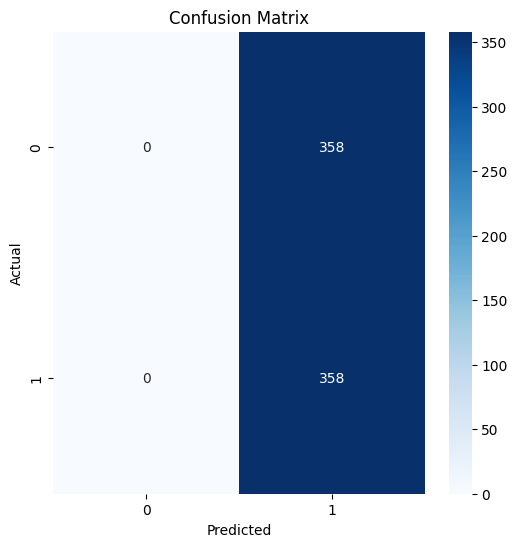

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Previsões do modelo

In [20]:
y_pred = (model.predict(padded_sequences_test) > 0.5).astype("int32")

23/23 [==============================] - 0s 2ms/step


### *ToDo*: O que você pode analisar dos resultados acima?

```
O conjunto de dados apresenta um desbalanceamento significativo entre as classes, com a classe 1 (Tóxico) sendo mais predominante, evidenciado pela alta taxa de recall para essa classe (98.04%).

Ao avaliar o desempenho diferencial entre as classes, observamos que a classe 0 (Não Tóxico) possui uma alta precisão (80%), indicando que o modelo geralmente acerta quando prevê que um texto é não tóxico.
No entanto, o recall para a classe 0 é muito baixo (7.82%), sugerindo que o modelo está perdendo muitas instâncias não tóxicas, o que pode ser problemático, especialmente se a detecção de textos não tóxicos for prioritária.

Para a classe 1 (Tóxico), a precisão é menor (51.54%), indicando que há uma chance menor de o modelo estar correto quando prevê que um texto é tóxico.
No entanto, o recall para a classe 1 é alto (98.04%), indicando que o modelo está efetivamente identificando a maioria dos textos tóxicos.

As médias macro e ponderada indicam que o desempenho médio do modelo é razoável, mas a ênfase nas métricas da classe majoritária pode mascarar questões importantes na detecção da classe minoritária.

Ao analisar o F1-score, observamos que, enquanto a classe 1 (Tóxico) mostra um equilíbrio razoável entre precisão e recall (67.56%), a classe 0 (Não Tóxico) apresenta um desequilíbrio significativo, com um F1-score baixo (14.25%).
```

# Faça o mesmo processamento utilizando GRU

Pelo menos duas camadas de GRU

In [21]:
from tensorflow.keras.layers import GRU

# Definição do modelo com camadas GRU
model_gru = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    GRU(32, return_sequences=True),
    GRU(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

# Treinamento do modelo
history_gru = model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

# Avaliação do modelo nos dados de teste
loss_gru, accuracy_gru = model_gru.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (GRU): {loss_gru:.4f}")
print(f"Acurácia nos dados de teste (GRU): {accuracy_gru:.4f}")

# Fazendo previsões no conjunto de teste
y_pred_gru = (model_gru.predict(padded_sequences_test) > 0.5).astype(int)

# Gerando o relatório de classificação sem warnings
report_gru = classification_report(y_test, y_pred_gru, target_names=encoder.classes_, output_dict=True)
print("Relatório de Classificação (GRU):")
for label, metrics in report_gru.items():
    if label == 'accuracy':
        continue
    print(f"Classe: {label}")
    print(f"\tPrecisão: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Média Macro (GRU): {report_gru['macro avg']}")
print(f"Média Ponderada (GRU): {report_gru['weighted avg']}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 gru (GRU)                   (None, 280, 32)           4800      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1612225 (6.15 MB)
Trainable params: 1612225 (6.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Faça o mesmo processamento utilizando LSTM

Pelo menos duas camadas de LSTM

In [22]:
from tensorflow.keras.layers import LSTM

# Definição do modelo com camadas LSTM
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# Treinamento do modelo
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

# Avaliação do modelo nos dados de teste
loss_lstm, accuracy_lstm = model_lstm.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (LSTM): {loss_lstm:.4f}")
print(f"Acurácia nos dados de teste (LSTM): {accuracy_lstm:.4f}")

# Fazendo previsões no conjunto de teste
y_pred_lstm = (model_lstm.predict(padded_sequences_test) > 0.5).astype(int)

# Gerando o relatório de classificação
report_lstm = classification_report(y_test, y_pred_lstm, target_names=encoder.classes_, output_dict=True)
print("Relatório de Classificação (LSTM):")
for label, metrics in report_lstm.items():
    if label == 'accuracy':
        continue
    print(f"Classe: {label}")
    print(f"\tPrecisão: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Média Macro (LSTM): {report_lstm['macro avg']}")
print(f"Média Ponderada (LSTM): {report_lstm['weighted avg']}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 lstm (LSTM)                 (None, 280, 32)           6272      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1615681 (6.16 MB)
Trainable params: 1615681 (6.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
72/72 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Faça o mesmo processamento utilizando GRU Bi-direcionais

Pelo menos duas camadas de GRU bi-direcionais

In [23]:
from tensorflow.keras.layers import Bidirectional

# Definição do modelo com camadas GRU bidirecionais
model_gru_bidirectional = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(GRU(32, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model_gru_bidirectional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru_bidirectional.summary()

# Treinamento do modelo
history_gru_bidirectional = model_gru_bidirectional.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

# Avaliação do modelo nos dados de teste
loss_gru_bidirectional, accuracy_gru_bidirectional = model_gru_bidirectional.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (GRU Bidirecional): {loss_gru_bidirectional:.4f}")
print(f"Acurácia nos dados de teste (GRU Bidirecional): {accuracy_gru_bidirectional:.4f}")

# Fazendo previsões no conjunto de teste
y_pred_gru_bidirectional = (model_gru_bidirectional.predict(padded_sequences_test) > 0.5).astype(int)

# Gerando o relatório de classificação
report_gru_bidirectional = classification_report(y_test, y_pred_gru_bidirectional, target_names=encoder.classes_, output_dict=True)
print("Relatório de Classificação (GRU Bidirecional):")
for label, metrics in report_gru_bidirectional.items():
    if label == 'accuracy':
        continue
    print(f"Classe: {label}")
    print(f"\tPrecisão: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Média Macro (GRU Bidirecional): {report_gru_bidirectional['macro avg']}")
print(f"Média Ponderada (GRU Bidirecional): {report_gru_bidirectional['weighted avg']}")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional (Bidirection  (None, 280, 64)           9600      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                18816     
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1630529 (6.22 MB)
Trainable params: 1630

# Faça o mesmo processamento utilizando LSTM Bi-direcionais

Pelo menos duas camadas de LSTM Bi-direcionais

# Faça o mesmo processamento utilizando redes recorrentes bi-direcionais e profundas

Pelo menos quatro camadas de GRU/LSTM bi-direcionais (ou não)

In [25]:
# Definição do modelo com camadas LSTM bidirecionais
model_lstm_bidirectional = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model_lstm_bidirectional.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_bidirectional.summary()

# Treinamento do modelo
history_lstm_bidirectional = model_lstm_bidirectional.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), verbose=2)

# Avaliação do modelo nos dados de teste
loss_lstm_bidirectional, accuracy_lstm_bidirectional = model_lstm_bidirectional.evaluate(padded_sequences_test, y_test, verbose=2)
print(f"Perda nos dados de teste (LSTM Bidirecional): {loss_lstm_bidirectional:.4f}")
print(f"Acurácia nos dados de teste (LSTM Bidirecional): {accuracy_lstm_bidirectional:.4f}")

# Fazendo previsões no conjunto de teste
y_pred_lstm_bidirectional = (model_lstm_bidirectional.predict(padded_sequences_test) > 0.5).astype(int)

# Gerando o relatório de classificação
report_lstm_bidirectional = classification_report(y_test, y_pred_lstm_bidirectional, target_names=encoder.classes_, output_dict=True)
print("Relatório de Classificação (LSTM Bidirecional):")
for label, metrics in report_lstm_bidirectional.items():
    if label == 'accuracy':
        continue
    print(f"Classe: {label}")
    print(f"\tPrecisão: {metrics['precision']}")
    print(f"\tRecall: {metrics['recall']}")
    print(f"\tF1-score: {metrics['f1-score']}")
print(f"Média Macro (LSTM Bidirecional): {report_lstm_bidirectional['macro avg']}")
print(f"Média Ponderada (LSTM Bidirecional): {report_lstm_bidirectional['weighted avg']}")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 280, 16)           1600000   
                                                                 
 bidirectional_2 (Bidirecti  (None, 280, 64)           12544     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1639489 (6.25 MB)
Trainable params: 1639

# *ToDo*: O que você pode analisar dos modelos treinados?

```
# Análise comparativa de desempenho:

Desempenho geral:

A acurácia varia de cerca de 0.50 a 0.64 nos diferentes modelos, o que indica que eles têm um desempenho moderado na tarefa de classificação.
A perda nos dados de teste varia de aproximadamente 0.69 a 1.41, sendo mais baixa nos modelos que utilizam camadas GRU e LSTM e mais alta nos modelos bidirecionais.

Comportamento das métricas de classificação:

Em geral, vemos pelas métricas de precisão, recall e F1-score que cada classe têm desempenho razoável, com F1-scores em torno de 0.64 na maioria dos casos.
As métricas de média macro e média ponderada também mostram desempenhos similares entre os modelos, com valores em torno de 0.64.


# Análise aprofundada:
Considerando os diferentes aspectos das arquiteturas dos modelos e como eles se relacionam com a natureza da tarefa em questão.

Arquitetura dos modelos:

*   GRU (Gated Recurrent Unit): Variantes de RNNs que abordam o problema do desaparecimento do gradiente, com menos parâmetros do que LSTMs, resultando em treinamento mais rápido, embora possam não capturar dependências de longo prazo tão eficazmente.
*   LSTM (Long Short-Term Memory): Projetadas para capturar dependências de longo prazo em sequências, superando o problema do desaparecimento do gradiente em RNNs tradicionais, possuindo mais parâmetros que GRUs, podendo ser mais suscetíveis ao sobreajuste.
*   Bidirecional: Processam sequências em ambas as direções, combinando informações contextuais de frente e trás, úteis para capturar contexto global, mas requerem mais recursos computacionais.

Complexidade do modelo:

Apesar de mais complexos, os modelos bidirecionais e os que usam duas camadas de LSTM ou GRU não traduziram essa maior quantidade de parâmetros em melhores resultados, como observado.

Desempenho relativo dos modelos:

*   Os modelos GRU e LSTM apresentaram desempenhos semelhantes em termos de acurácia e métricas de classificação. Isso sugere que, para o conjunto de dados e a tarefa em questão, as diferenças nas capacidades de captura de dependências temporais de longo prazo entre GRU e LSTM podem não ter um impacto significativo no desempenho final. Isso se deve a:
1.   Brevidade do treinamento: O treinamento foi relativamente breve, portanto os modelos podem não ter tido tempo suficiente para aprender as nuances mais sutis dos dados. Isso pode ter limitado a capacidade dos modelos de aproveitar ao máximo as diferenças entre GRU e LSTM.
2.   Tamanho do conjunto de dados: O conjunto de dados utilizado para treinamento foi relativamente pequeno (5,668 tweets), os modelos podem não ter sido capazes de explorar totalmente as capacidades das arquiteturas mais complexas, como LSTMs. Modelos mais simples, como GRUs, podem ter sido mais eficientes em aprender representações úteis com menos dados.
3.   Complexidade da tarefa: Considerando, no contexto de *tweets*, que a classificação de sentimentos se baseou-se mais em palavras ou frases individuais do que em contextos mais amplos, não exigindo tanto de dependências temporais de longo prazo, então as diferenças entre GRU e LSTM podem não ter tido um impacto significativo no desempenho.

*  Os modelos bidirecionais mostraram desempenhos semelhantes em termos de acurácia geral, mas as métricas de precisão, recall e F1-score para cada classe variaram. Comparando os resultados dos modelos LSTM unidirecionais com os bidirecionais, observou-se que estes últimos tendem a apresentar métricas ligeiramente melhores em termos de precisão, recall e F1-score para ambas as classes. O mesmo padrão foi observado ao comparar os resultados dos modelos GRU unidirecionais com os bidirecionais, embora as diferenças não fossem tão proeminentes quanto no caso dos LSTMs. Isso sugere que a capacidade dos modelos bidirecionais de capturar informações contextuais de ambas as direções da sequência pode proporcionar benefícios adicionais na discriminação entre as classes.


```